# Логарифмированные острова

In [1]:
import numpy as np
import pandas as pd

y = np.log(pd.read_csv('islands.csv', header=0, index_col=0).values.flatten())

## Гистограмма

In [2]:
# hardcore way using numpy
hist = np.histogram(y, range=(0, 12), bins=12, density=False)
# range - границы области определения гистограммы
# bins - количество столбцов гистограммы (можно задать не количество, а границы столбцов)
# density - если False, возвращается количество наблюдений, попавших в каждый из интервалов,
#           если True, - средняя плотность распрееления на интервалах

print(hist[0])
print(hist[1])
# hist[0] - количество наблюдений / плотность
# hist[1] - границы интервалов

[ 0  0 12 17  6  5  1  1  3  3  0  0]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


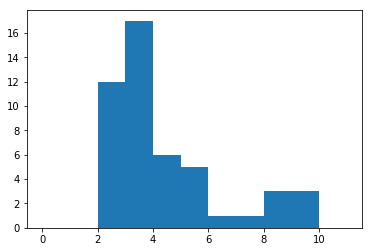

In [3]:
# softcore way using matplotlib
import matplotlib.pyplot as plt

plt.hist(y, bins=range(0, 12), density=False)
plt.show()

## Простая непараметрическая оценка плотности

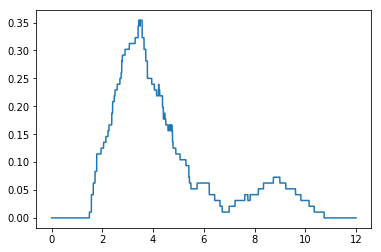

In [6]:
L = 10 ** 4
N = len(y)
h = 2.  # ширина интервала

# в точках х будет оцениваться плотность
x = np.linspace(0, 12, num=L)
f_naive = np.zeros(L, np.float64)  # нулевой (пока) вектор оценок плотности
for i in range(L):
    f_naive[i] = ((y >= x[i] - h / 2) * (y <= x[i] + h / 2)).sum()
f_naive /= N * h

plt.plot(x, f_naive)
plt.show()

## Ядерная оценка плотности

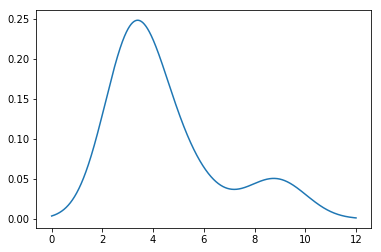

In [7]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(y, bw_method='silverman')

plt.plot(x, kde(x))
plt.show()

In [8]:
# оптимальное значение сглаживающего множителя
h_opt = kde.covariance_factor() * y.std()
print('h_opt:', h_opt)

# kde.covariance_factor() зависит от количества наблюдений и размерности данных
d = len(y.shape)
h_silverman = (N * (d + 2) / 4) ** (-1 / (d + 4)) * y.std()
print('h_silverman:', h_silverman)
h_scott = N ** (-1 / (d + 4)) * y.std()
print('h_scott:', h_scott)

h_opt: 1.002742465952426
h_silverman: 1.002742465952426
h_scott: 0.946676639150739


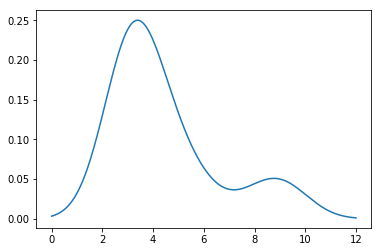

In [11]:
# если хочется другое ядро
from sklearn.neighbors import KernelDensity

kd = KernelDensity(kernel='gaussian', bandwidth=h_opt)
# kernel in ('gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine')
kd.fit(y.reshape(-1, 1))

plt.plot(x, np.exp(kd.score_samples(x.reshape(-1, 1))))
plt.show()

## Генератор случайных чисел по построенной оценке плотности

In [15]:
kde.resample(size=10)

array([[1.44328663, 9.574266  , 3.54426528, 4.53818536, 4.09324612,
        3.78905684, 4.72129475, 2.72326444, 4.88800112, 2.97011505]])

## Нахождение квантилей распределения

In [16]:
def sample_quntile(kde, q: float, sample_size: int = 10 ** 6):
    """
    1. Генерируем множество случайных значений, подчиняющихся найденному закону распределения
    2. Сортируем их по возрастанию
    3. Вытаскиваем номер, пропорциональный заданному квантилю
    """
    assert 0. <= q <= 1.
    sampled_values = np.sort(kde.resample(size=sample_size).flatten())
    return sampled_values[round(q * sample_size)]

sample_quntile(kde, q=0.99)

10.583933209004018

## Адаптивная ядерная оценка

-7.873388102946662 16.76607009572421
10.45034538693399


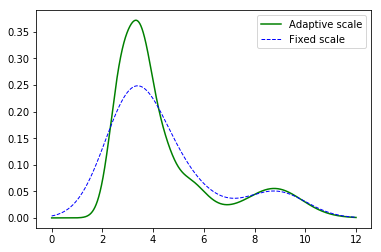

In [17]:
from scipy.stats.mstats import gmean
from scipy.stats import norm
# norm.pdf(x) - ядро Гаусса

class adaptive_kde:
    def __init__(self, y):
        self.y = y
        self.N = len(y)
        
    def pdf(self, x, alpha=0.5):
        # применяем адаптивный метод с лямбдой
        pilot = gaussian_kde(self.y, bw_method='silverman')
        pilot_pdf = pilot(self.y)
        h = pilot.covariance_factor()  # оценка глобальной составляющей интервала
        g = gmean(pilot_pdf)  # среднегеометрическое пилотных оценок
        lambda_ = (g / pilot_pdf) ** alpha  # расчёт локальной концентрации наблюдений
        
        # расчёт оценок плотности
        L = len(x)
        f = np.zeros(L, np.float64)
        for i in range(L):
            f[i] = (norm.pdf((x[i] - y) / (h * lambda_)) / (h * lambda_)).mean()
        return f
    
    def sample_quantile(self, q: float, range_in_sigmas: int = 6, grid_size: int = 10 ** 4, sample_size: int = 10 ** 6):
        assert 0. <= q <= 1.
        mu, sigma = self.y.mean(), self.y.std()
        print(mu - range_in_sigmas * sigma, mu + range_in_sigmas * sigma)
        x = np.linspace(mu - range_in_sigmas * sigma, mu + range_in_sigmas * sigma, num=grid_size)
        probs = self.pdf(x)
        probs /= probs.sum()
        sample_values = np.sort(np.random.choice(x, size=sample_size, p=probs, replace=True))
        return sample_values[round(q * sample_size)]
    
akde = adaptive_kde(y)
print(akde.sample_quantile(0.99))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, akde.pdf(x), '-', color='green', label='Adaptive scale')
ax.plot(x, kde(x), '--', color='blue', linewidth=1, label='Fixed scale')
plt.legend()
plt.show()